# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
sentences = []
word_threshold = 128

for text in dataset['train']['text']:
    sentences.extend([x.lower() for x in sent_tokenize(text) if len(x) < word_threshold])

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 177208


In [ ]:
print(sentences[:5])

["really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.", 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.', 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.', "but really, this film doesn't have much of a plot.", '"i am curious: yellow" is a risible and pretentious steaming pile.']


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()
for text in sentences:
    for word in word_tokenize(text):
        words[word] += 1

In [ ]:
len(words)

59187

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 4000
for key, value in sorted(words.items(), key=lambda x: x[1], reverse=True)[:4000]:
    vocab.add(key)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 4004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id] + [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])] + [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, loader, optimizer, criterion, epochs):
    perplexity = []
    losses = []
    for epoch in range(epochs):
        model.train()
        loss_ep = []
        for batch in tqdm(loader):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            loss_ep.append(loss.item())
        perplexity.append(evaluate(model, criterion, eval_dataloader))
        losses.append(sum(loss_ep) / len(loss_ep))
    return perplexity, losses

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size : int, hidden_dim: int, n_layers=1):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.LSTM(hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.gru(embeddings)
        out = self.linear(self.non_lin(output))
        projection = self.projection(self.non_lin(out))
        return projection

In [ ]:
model_lstm = LSTMModel(vocab_size=len(vocab), hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm.parameters())

In [ ]:
perplexity_lstm, losses_lstm = train_model(model_lstm, train_dataloader, optimizer, criterion, epochs=25)

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

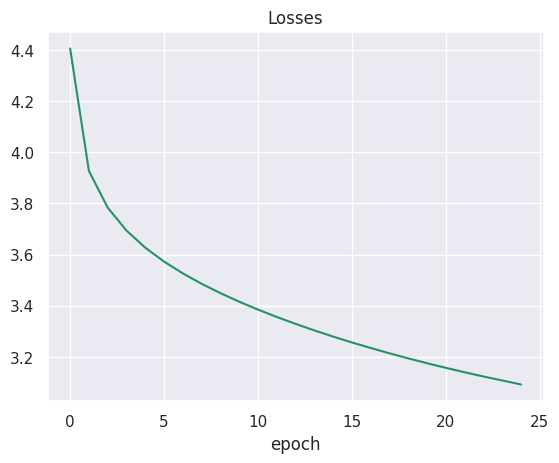

In [ ]:
plt.plot(np.arange(len(losses_lstm)), losses_lstm)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

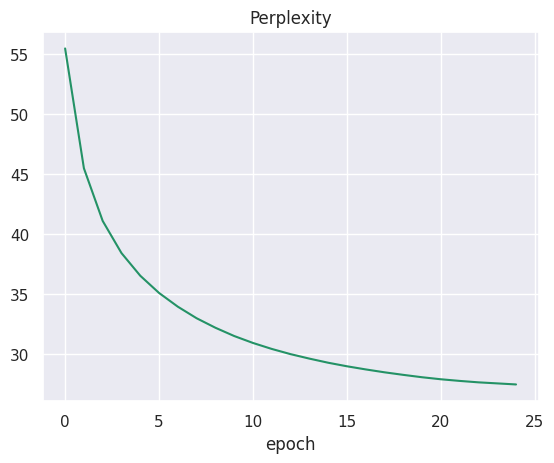

In [ ]:
plt.plot(np.arange(len(perplexity_lstm)), perplexity_lstm)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [ ]:
generate_sequence(model_lstm, starting_seq='i see')

"<bos> i see a lot of movies that are so <unk> that i 'm sure it 's a <unk> . <eos>"

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
class LSTMModelDO(nn.Module):
    def __init__(self, vocab_size : int, hidden_dim: int, n_layers=1):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.rnn(embeddings)
        out = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(out))
        return projection

In [ ]:
model_do = LSTMModelDO(vocab_size=len(vocab), hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_do.parameters())

In [ ]:
perplexity_do, losses_do = train_model(model_do, train_dataloader, optimizer, criterion, epochs=25)

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

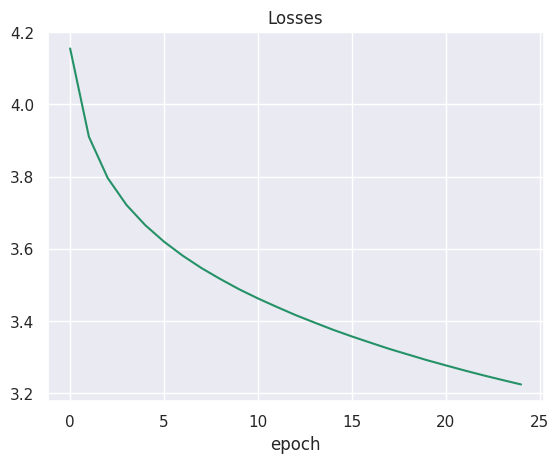

In [ ]:
plt.plot(np.arange(len(losses_do)), losses_do)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

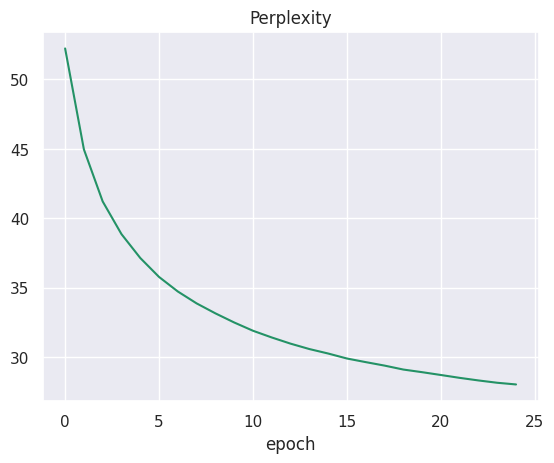

In [ ]:
plt.plot(np.arange(len(perplexity_do)), perplexity_do)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
generate_sequence(model_do, starting_seq='i see')

'<bos> i see some <unk> <unk> <unk> . <eos>'

## Третий эксперимент

In [ ]:
model_2l = LSTMModel(vocab_size=len(vocab), hidden_dim=256, n_layers=2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_2l.parameters())

In [ ]:
perplexity_2l, losses_2l = train_model(model_2l, train_dataloader, optimizer, criterion, epochs=25)

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/1108 [00:00<?, ?it/s]

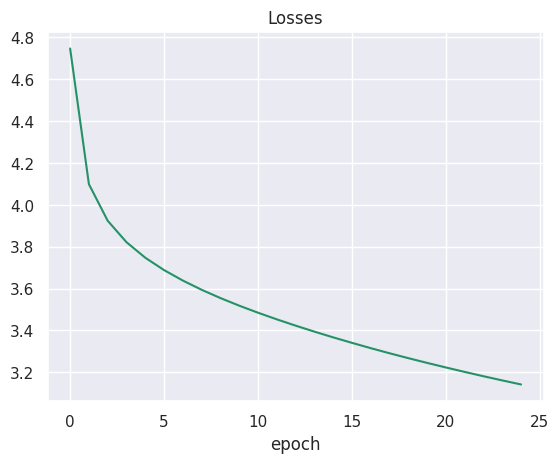

In [ ]:
plt.plot(np.arange(len(losses_2l)), losses_2l)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

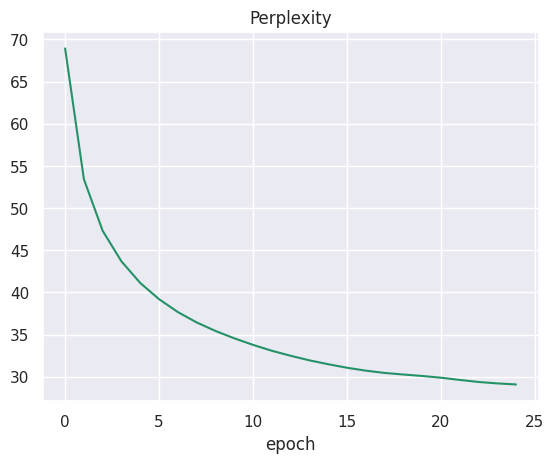

In [ ]:
plt.plot(np.arange(len(perplexity_2l)), perplexity_2l)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
generate_sequence(model_2l, starting_seq='i see')

'<bos> i see a lot of the characters <unk> and <unk> . <eos>'

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

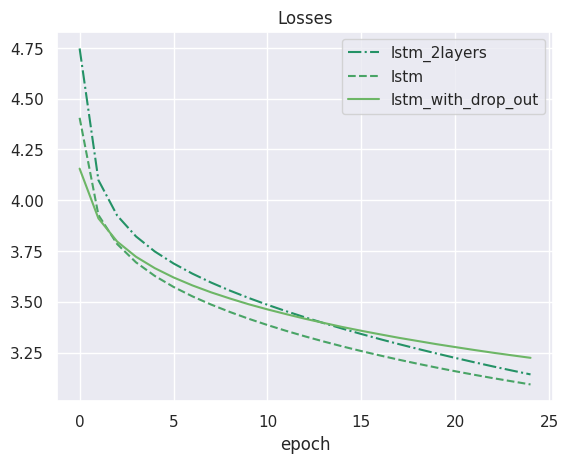

In [ ]:
plt.plot(np.arange(len(losses_2l)), losses_2l, label='lstm_2layers', linestyle="-.")
plt.plot(np.arange(len(losses_lstm)), losses_lstm, label='lstm', linestyle="--")
plt.plot(np.arange(len(losses_do)), losses_do, label='lstm_with_drop_out')
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

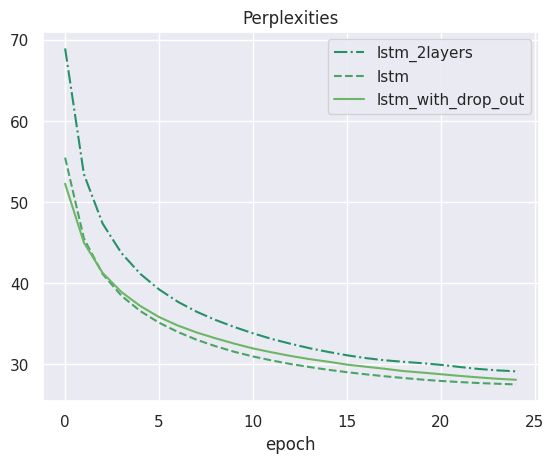

In [ ]:
plt.plot(np.arange(len(perplexity_2l)), perplexity_2l, label='lstm_2layers', linestyle="-.")
plt.plot(np.arange(len(perplexity_lstm)), perplexity_lstm, label='lstm', linestyle="--")
plt.plot(np.arange(len(perplexity_do)), perplexity_do, label='lstm_with_drop_out')
plt.title('Perplexities')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
seq1 = generate_sequence(model_2l, starting_seq='he has a cat')
seq2 = generate_sequence(model_do, starting_seq='he has a cat')
seq3 = generate_sequence(model_lstm, starting_seq='he has a cat')

In [ ]:
print('simple lstm:', seq3)
print('lstm with 2 layers:', seq1)
print('lstm with drop out:', seq2)

simple lstm: <bos> he has a cat and mouse chase with a <unk> <unk> . <eos>
lstm with 2 layers: <bos> he has a cat and <unk> to <unk> <unk> . <eos>
lstm with drop out: <bos> he has a cat and mouse chase with a <unk> of <unk> . <eos>


Наилучшие значения перплексии и функции потерь при обучении показывает модель без множественных рекурентных слоев и без применения нормализаций. При генерации пробных предложений простая модель также показывает лучший реультат.